In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from pyCompare import blandAltman

test_path = "../results/hold-out-test.csv"
external_all_path = "../results/external-data.csv"
prospective_all_path = "../results/prospective-data.csv"

figureSize = (4, 4)


def dice_plot(
    x,
    y,
    title,
    figureSize=figureSize,
    x_label="Reference htTKV (mL)",
    y_label="Dice Similarity Coefficient",
):

    dpi = 72
    fig, ax = plt.subplots(figsize=figureSize, dpi=dpi)
    draw = True
    meanColour = "#6495ED"
    loaColour = "coral"
    pointColour = "#6495ED"

    ax.scatter(x, y, alpha=0.5, c=pointColour)

    mean = np.mean(y)
    sd = np.std(y)
    sd95 = 1.96 * np.std(y)
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    offset = 0.08
    ax.text(
        0.97,
        mean - 2 * offset,
        f"Mean {mean:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        mean - 3 * offset,
        f"SD {sd:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        mean - 4 * offset,
        f"±1.96 SD in coral",
        ha="right",
        va="bottom",
        transform=trans,
    )

    ax.axhspan(mean - sd95, mean + sd95, facecolor=loaColour, alpha=0.2)

    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, pad=10)
    ax.set_ylim([0, 1.05])
    ax.axhline(np.mean(y), color=meanColour, linestyle="--")

    ax.set_yticks(np.arange(0, 1.1, 0.1))



In [2]:
# external_ds = pd.read_csv(external_path)
# prospective_ds = pd.read_csv(prospective_path)
prospective_ds = pd.read_csv(prospective_all_path)
prospective_ds.TKV_Pred /= 1000  # corrects units to mL
prospective_ds.TKV_GT /= 1000  # corrects units to mL

test_ds = pd.read_csv(test_path)
test_ds.TKV_GT /= 1000  # corrects units to mL
test_ds.TKV_Pred /= 1000  # corrects units to mL


external_ds = pd.read_csv(external_all_path)
# prospective_ds = pd.read_csv(prospective_all_path)



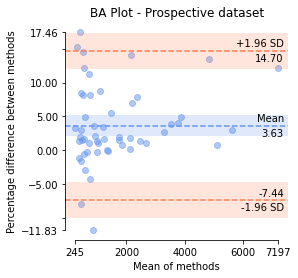

In [3]:

blandAltman(
    prospective_ds.TKV_GT,
    prospective_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Prospective dataset",
    figureSize=figureSize,
)

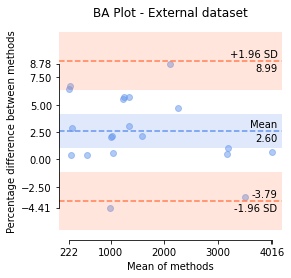

In [4]:
blandAltman(
    external_ds.TKV_GT,
    external_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - External dataset",
    figureSize=figureSize,
)

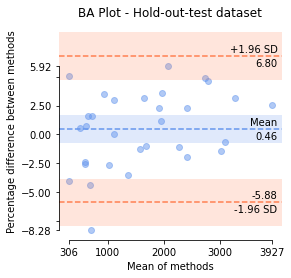

In [5]:
blandAltman(
    test_ds.TKV_GT,
    test_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Hold-out-test dataset",
    figureSize=figureSize,
)



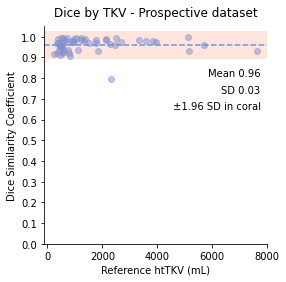

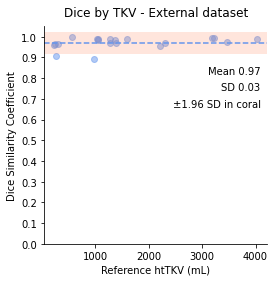

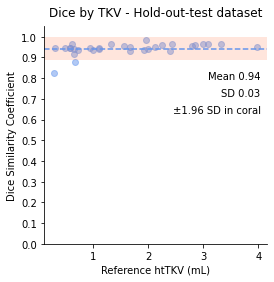

In [6]:
dice_plot(
    prospective_ds.TKV_GT,
    prospective_ds.patient_dice,
    title="Dice by TKV - Prospective dataset",
    figureSize=figureSize,
)


dice_plot(
    external_ds.TKV_GT,
    external_ds.patient_dice,
    title="Dice by TKV - External dataset",
    figureSize=figureSize,
)


dice_plot(
    test_ds.TKV_GT / 1000,
    test_ds.patient_dice,
    title="Dice by TKV - Hold-out-test dataset",
    figureSize=figureSize,
)
